<a href="https://colab.research.google.com/github/JeremyQuijano/ph582_final_project_group_f/blob/main/intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

a couple of plots to show the structure of dataset and an unsuccessfull attempt of clustering  

In [ ]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [ ]:
!ls gdrive/Shareddrives/ML\ project

gizmo_analysis	m12i				    plots_sample_b
intro.ipynb	ph582_final_project_group_f.ipynb   rockstar_analysis
m12f		ph582_presentation_group_f.gslides  utilities


In [ ]:
%cd gdrive/Shareddrives/ML\ project

/content/gdrive/Shareddrives/ML project


In [ ]:
!pip install umap-learn

     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 1.2MB 31.2MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=c63670ce3d00887b5a43b48435b46a83c821162752b1e30e71439892a03e9807
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=aa7dd3c71932b2cf44035b31e267daaba703daa9aeb44771c9b837632ca459bf
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [ ]:
import gizmo_analysis as gizmo
import utilities as ut
import os
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ImageNormalize, LogStretch
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

Read snapshots from path/output directory

In [ ]:
part = gizmo.io.Read.read_snapshots(['star'], 'index', 600,
   	                                simulation_directory='m12f', 
                                    assign_host_principal_axes=True,  # assgin host principal axis — to put 0 of coords to host galaxy center
                                    assign_formation_coordinates=True) # to track formation coordinates  


# in utilities.simulation.Snapshot():
* reading:  m12f/snapshot_times.txt

  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  m12f/output/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 96239056 particles
    dark2     (id = 2): 7591203 particles
    gas       (id = 0): 80307825 particles
    star      (id = 4): 16066489 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

! cannot find MUSIC config file:  m12f/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA box):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties
! warning: star id.child [min, max] = [0.000, 4.289e9]
! warning: star mass [min, med, max] = [3307.548, 5390.065, 5456

In [ ]:
hist_xy = np.histogram2d(part['star'].prop('host.distance.principal').T[0], part['star'].prop('host.distance.principal').T[1], bins=2048, range=[[-50, 50], [-50, 50]])  # range is in kpc, otherwise side of the box is too large

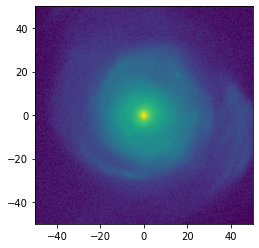

In [ ]:
plt.imshow(hist_xy[0].T, norm=ImageNormalize(stretch=LogStretch(a=100000)), 
           extent=(hist_xy[1][0], hist_xy[1][-1], hist_xy[2][0], hist_xy[2][-1]), origin='zero')
plt.show()

filter star particles based on their formation radius

In [ ]:
idxs_star = np.where((part['star'].prop('form.host.distance.principal.total')<20)) 

In [ ]:
len(idxs_star[0])

14114598

In [ ]:
hist_xy = np.histogram2d(part['star'].prop('host.distance.principal').T[0][idxs_star], 
                         part['star'].prop('host.distance.principal').T[1][idxs_star], bins=2048, range=[[-30, 30], [-30, 30]])

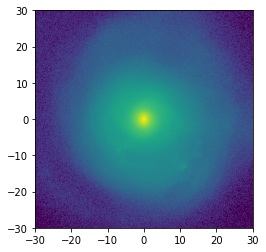

In [ ]:
plt.imshow(hist_xy[0].T, norm=ImageNormalize(stretch=LogStretch(a=100000)), 
           extent=(hist_xy[1][0], hist_xy[1][-1], hist_xy[2][0], hist_xy[2][-1]), origin='zero')
plt.show()

Fe/H - O/Fe diagram

In [ ]:
hist_met = np.histogram2d(part['star'].prop('metallicity.fe')[idxs_star], 
                         part['star'].prop('metallicity.o-metallicity.fe')[idxs_star], bins=2048, range=[[-1., 1.], [-0.2, 0.8]])  # change to range=[[-4., 1.], [-0.2, 0.8]] to see whole diagram

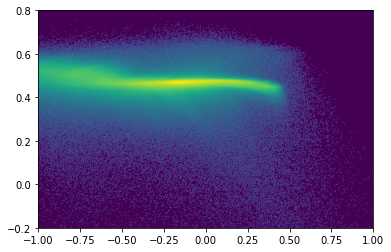

In [ ]:
plt.imshow(hist_met[0].T, norm=ImageNormalize(stretch=LogStretch(a=100000)), 
           extent=(hist_met[1][0], hist_met[1][-1], hist_met[2][0], hist_met[2][-1]),
           origin='zero', aspect='auto')
plt.show()

compare with diagram for all stars, there is substructure just at around (-0.25, 0.4)

In [ ]:
hist_met = np.histogram2d(part['star'].prop('metallicity.fe'), 
                         part['star'].prop('metallicity.o-metallicity.fe'), bins=2048, range=[[-1., 1.], [-0.2, 0.8]])

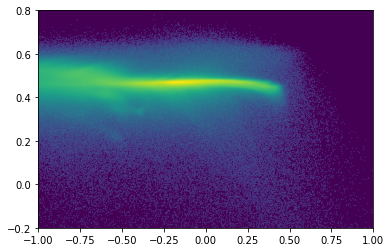

In [ ]:
plt.imshow(hist_met[0].T, norm=ImageNormalize(stretch=LogStretch(a=100000)), 
           extent=(hist_met[1][0], hist_met[1][-1], hist_met[2][0], hist_met[2][-1]),
           origin='zero', aspect='auto')
plt.show()

attempt to do some clustering. it's not working with these parameters, but I hope we will find something

In [ ]:
k = 1000
feh = part['star'].prop('metallicity.fe')[idxs_star][::k]
ofe = part['star'].prop('metallicity.o-metallicity.fe')[idxs_star][::k]
mgfe = part['star'].prop('metallicity.mg-metallicity.fe')[idxs_star][::k]
sife = part['star'].prop('metallicity.si-metallicity.fe')[idxs_star][::k]
cafe = part['star'].prop('metallicity.ca-metallicity.fe')[idxs_star][::k]
cfe = part['star'].prop('metallicity.c-metallicity.fe')[idxs_star][::k]
nefe = part['star'].prop('metallicity.ne-metallicity.fe')[idxs_star][::k]
nfe = part['star'].prop('metallicity.n-metallicity.fe')[idxs_star][::k]
sfe = part['star'].prop('metallicity.s-metallicity.fe')[idxs_star][::k]
ages = part['star'].prop('age')[idxs_star][::k]
x = part['star'].prop('host.distance.principal').T[0][idxs_star][::k]
y = part['star'].prop('host.distance.principal').T[1][idxs_star][::k]
z = part['star'].prop('host.distance.principal').T[2][idxs_star][::k]
R = np.sqrt(x**2 + y**2 + z**2)
vx = part['star'].prop('host.velocity.principal').T[0][idxs_star][::k]
vy = part['star'].prop('host.velocity.principal').T[1][idxs_star][::k]
vz = part['star'].prop('host.velocity.principal').T[2][idxs_star][::k]
vR = part['star'].prop('host.velocity.principal.cylindrical').T[0][idxs_star][::k]
vphi = part['star'].prop('host.velocity.principal.cylindrical').T[1][idxs_star][::k]
Rbirth = part['star'].prop('form.host.distance.total')[idxs_star][::k]
xb = part['star'].prop('form.host.distance.principal').T[0][idxs_star][::k]
yb = part['star'].prop('form.host.distance.principal').T[1][idxs_star][::k]
zb = part['star'].prop('form.host.distance.principal').T[2][idxs_star][::k]

In [ ]:
data_subset = np.array([feh, ofe, mgfe, cafe, sife, nfe, nefe, sfe, cfe]).T

# t-SNE

In [ ]:
def plot_results(data, c, clabel, xlabel='t-SNE 2d - one', ylabel='t-SNE 2d - two', **kw):
    if 'clim' in kw:
        vmin, vmax = kw['clim']
    else:
        vmin, vmax = [np.min(c), np.max(c)]
    if data.shape[1] == 2:
        plt.figure(figsize=(10, 8))
        plt.scatter(data[:, 0], data[:, 1], c=c, cmap='Spectral', s=1, vmin=vmin, vmax=vmax)
        plt.gca().set_aspect('equal', 'datalim')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.colorbar(label=clabel)
        if 'method' in kw:
            plt.title(kw['method'], fontsize=11)
        if 'fname' in kw:
            plt.tight_layout()
            plt.savefig(kw['fname']+'.png', dpi=120)
        plt.show()
        plt.close()

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=500, learning_rate=1000,
            random_state=42)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 14115 samples in 0.017s...
[t-SNE] Computed neighbors for 14115 samples in 1.298s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14115
[t-SNE] Computed conditional probabilities for sample 2000 / 14115
[t-SNE] Computed conditional probabilities for sample 3000 / 14115
[t-SNE] Computed conditional probabilities for sample 4000 / 14115
[t-SNE] Computed conditional probabilities for sample 5000 / 14115
[t-SNE] Computed conditional probabilities for sample 6000 / 14115
[t-SNE] Computed conditional probabilities for sample 7000 / 14115
[t-SNE] Computed conditional probabilities for sample 8000 / 14115
[t-SNE] Computed conditional probabilities for sample 9000 / 14115
[t-SNE] Computed conditional probabilities for sample 10000 / 14115
[t-SNE] Computed conditional probabilities for sample 11000 / 14115
[t-SNE] Computed conditional probabilities for sample 12000 / 14115
[t-SNE] Computed conditional probabilities for sa

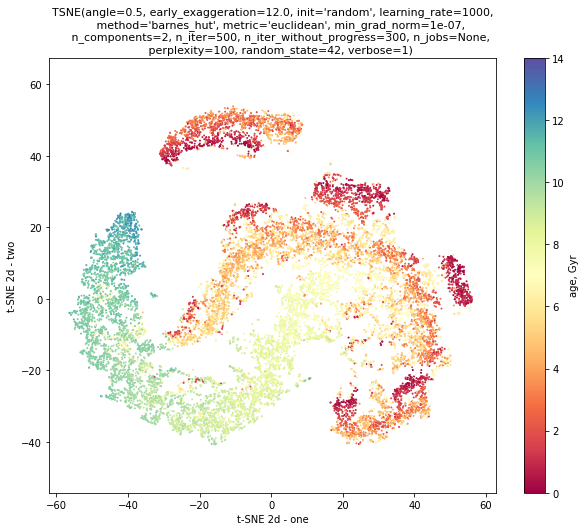

In [ ]:
plot_results(tsne_results, ages, 'age, Gyr', method=str(tsne), clim=[0., 14.])

# UMAP

In [ ]:
reducer = umap.UMAP(random_state=42, n_neighbors=20, min_dist=0.01, metric='minkowski', n_components=2)
reducer.fit(data_subset)

UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='minkowski',
     metric_kwds=None, min_dist=0.01, n_components=2, n_epochs=None, n_jobs=-1,
     n_neighbors=20, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)

In [ ]:
embedding = reducer.transform(data_subset)

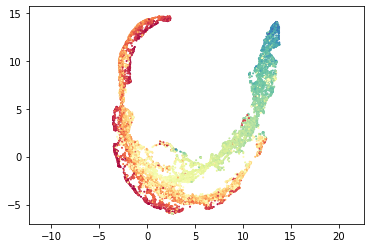

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=ages, cmap='Spectral', s=1)
plt.gca().set_aspect('equal', 'datalim')

# DBSCAN

In [ ]:
clustering = DBSCAN(eps=0.01, min_samples=5).fit(data_subset)

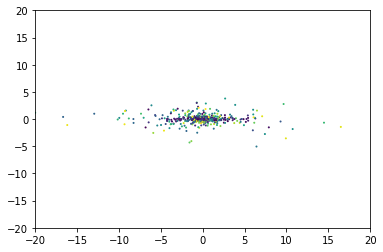

In [ ]:
plt.figure()
plt.scatter(x[clustering.labels_>1], z[clustering.labels_>1], c=clustering.labels_[clustering.labels_>1], s=1.)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.show()
plt.close()